# MMIS692 Customer Segmentation

Our goal is to classify customers into segments based on input features that represent customer characteristics. 
1. We shall train and evaluate candidate classifers using the labeled training samples in the file "*customer_segmentation.train.csv*" through *5-fold cross-validation*, eliminating irrelevant input features if possible.
2. Choose a classifier that performs well, find a good set of hyper-parameters for the classifier through cross-validation, train our model with chosen hyper-parameters on the training examples, and evaluate its classification accuracy on the labeled validation samples in the file "*customer_segmentation.valid.csv*"
3. Use our trained model to classify customers in the file "*customer_segmentation.unlabeled.csv*" into segments, based on their characteristics.   


## Import libraries

A list of available *Scikit-Learn* supervised learning classifiers is available at https://scikit-learn.org/stable/supervised_learning.html 

Use any classifier that you are familiar with. 

In [29]:
import zipfile as zf
import pandas as pd # for data handling
import matplotlib.pyplot as plt # for plotting
from time import time # to record time for training and cross-validation

# scikit-learn classifiers (import other classifiers if you want to)
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix # to evaluate models

from sklearn.model_selection import cross_val_score, GridSearchCV # for cross-validation and tuning hyper-parameters

import warnings
warnings.filterwarnings("ignore") # ignore warnings

## Get data

For this task, we are going to use data from 3 CSV files:
- '*customer_segmentation.train.csv*'
- '*customer_segmentation.valid.csv*'
- '*customer_segmentation.unlabeled.csv*'


In [30]:
# ! unzip '/content/drive/MyDrive/Colab Notebooks/courses/MMIS692_Summer2021/data.MMIS692.Sample.zip'

files = zf.ZipFile('data.MMIS692.Sample.zip', 'r')
files.extractall()
files.close()

train = pd.read_csv('customer_segmentation.train.csv')
valid = pd.read_csv('customer_segmentation.valid.csv')
unlabeled = pd.read_csv('customer_segmentation.unlabeled.csv')
# ! rm *.csv

## Specify classifiers
We shall use the following *sklearn* classifiers with default hyper-parameters.

You can use any set of classifiers that you want.

In [31]:
CLF = {} # dictionary of classifiers
CLF['GNB'] = GaussianNB()
CLF['DT'] = DecisionTreeClassifier()
CLF['RF'] = RandomForestClassifier()
CLF['ET'] = ExtraTreesClassifier()
CLF['AB'] =  AdaBoostClassifier()
CLF['SGD'] = SGDClassifier()
CLF['Ridge'] = RidgeClassifier()
CLF['LR'] = LogisticRegression(max_iter=1000)
CLF['Lin_SVC'] = LinearSVC()
CLF['SVC'] = SVC()
CLF['KNN'] = KNeighborsClassifier()
CLF['MLP'] = MLPClassifier()

print('Classifiers:')
for c in CLF:
    print(f'{c} : {CLF[c].__class__.__name__}')

Classifiers:
GNB : GaussianNB
DT : DecisionTreeClassifier
RF : RandomForestClassifier
ET : ExtraTreesClassifier
AB : AdaBoostClassifier
SGD : SGDClassifier
Ridge : RidgeClassifier
LR : LogisticRegression
Lin_SVC : LinearSVC
SVC : SVC
KNN : KNeighborsClassifier
MLP : MLPClassifier


## Evaluate classifiers
We shall train the classifiers on all available features using *5 fold cross-validation* on just the training data. 

In [32]:
features = list(train)[1:] # input features
res = [] # list with results
for c in CLF: # for each classifier
    model = CLF[c] # create classifier object with default hyper-parameters
    st = time() # start time for 5-fold cross-validation
    score = cross_val_score(model, train[features], train.y).mean() # mean cross-validation accuracy
    t = time() - st # # time for 5-fold cross-validation
    print(c, round(score,4), round(t,2)) # show results for classifier
    res.append([c, score, t]) # append results for classifier
pd.DataFrame(res, columns=['model', 'score', 'time']).round(4) # show results as dataframe

GNB 0.9215 0.14
DT 0.909 6.09
RF 0.9686 36.68
ET 0.9712 8.26
AB 0.9062 14.49
SGD 0.9196 1.61
Ridge 0.9274 0.11
LR 0.9321 0.84
Lin_SVC 0.9303 18.58
SVC 0.978 12.57
KNN 0.9772 4.89
MLP 0.9497 66.97


,model,score,time
0,GNB,0.9215,0.1386
1,DT,0.9090,6.0870
2,RF,0.9686,36.6848
3,ET,0.9712,8.2587
4,AB,0.9062,14.4871
5,SGD,0.9196,1.6147
6,Ridge,0.9274,0.1096
7,LR,0.9321,0.8369
8,Lin_SVC,0.9303,18.5824
9,SVC,0.9780,12.5672


## Eliminate irrelevant features

We shall use the '*feature_importances_*' attribute of a trained *ExtraTreesClassifier* model to estimate the importance of each feature, sort the features based on importance, and check if some of the features seem irrelevant for this classification task.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
importance,0.103,0.102,0.1,0.098,0.096,0.057,0.056,0.055,0.054,0.046,0.042,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005
feature,x22,x43,x8,x2,x36,x19,x25,x18,x46,x32,x47,x34,x30,x50,x35,x3,x21,x24,x17,x15


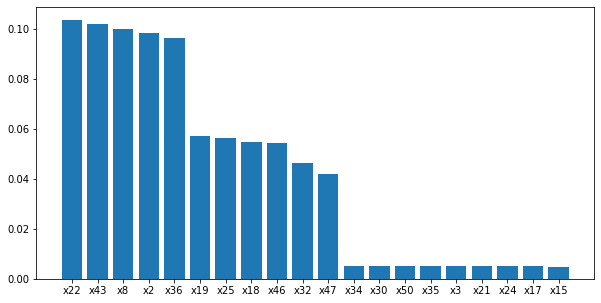

In [33]:
ET = ExtraTreesClassifier().fit(train[features], train.y) # Train ExtraTreesClassifier
fi = sorted([(imp, f) for imp, f in zip(ET.feature_importances_, features)], reverse=True) # features sorted in descending order of importance
k = 20 # consider the k most important features (change as desired)
plt.figure(figsize=(10, 5)) # size of figure to be displayed
_ = plt.bar([v[1] for v in fi][:k], [v[0] for v in fi][:k]) # plot importance
pd.DataFrame(fi[:k], columns=['importance', 'feature']).round(3).T # show importance

We identify a list of *relevant_features* and then use only these relevant features to train models.

In [34]:
k = 11
relevant_features = [v[1] for v in fi][:k] 
print("Relevant features:", ', '.join(relevant_features))

Relevant features: x22, x43, x8, x2, x36, x19, x25, x18, x46, x32, x47


## Evaluate models using relevant features

In [35]:
res = [] # list with results
for c in CLF: # for each classifier
    model = CLF[c] # create classifier object with default hyper-parameters
    st = time() # start time for 5-fold cross-validation
    score = cross_val_score(model, train[relevant_features], train.y).mean() # mean cross-validation accuracy
    t = time() - st # # time for 5-fold cross-validation
    print(c, round(score,4), round(t,2)) # show results for classifier
    res.append([c, score, t]) # append results for classifier
res_df = pd.DataFrame(res, columns=['model', 'mean accuracy', 'time']).round(4) # show results as dataframe
res_df.to_csv('cross_validation_results.csv', index=False)
res_df

GNB 0.9212 0.05
DT 0.9226 1.0
RF 0.973 14.87
ET 0.9761 3.75
AB 0.9126 4.12
SGD 0.9266 0.56
Ridge 0.9268 0.05
LR 0.9327 0.55
Lin_SVC 0.9304 5.07
SVC 0.98 6.11
KNN 0.981 1.85
MLP 0.9793 43.61


,model,mean accuracy,time
0,GNB,0.9212,0.0456
1,DT,0.9226,1.0042
2,RF,0.9730,14.8660
3,ET,0.9761,3.7498
4,AB,0.9126,4.1234
5,SGD,0.9266,0.5643
6,Ridge,0.9268,0.0480
7,LR,0.9327,0.5509
8,Lin_SVC,0.9304,5.0716
9,SVC,0.9800,6.1130


## Choose good model

Based on cross-validation results we shall create a short-list of the best performing models and then use Grid Search to find a good set of hyper-parameters for these models through cross-validation. 

In [45]:
para = {'C':[0.1, 1.0, 5.0, 10.0]}
clf = GridSearchCV(SVC(), para, scoring='accuracy', 
                   n_jobs=-1, verbose=1) # grid search model

print(clf) # show model
print()

print("Tuning hyper-parameters ... " )
clf.fit(train[relevant_features], train.y) # tune using 5-fold cross-validation

print()
print("Accuracy: mean +/- 2*standard_dev") # show results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))
    
print("Best parameters:", clf.best_params_)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1.0, 5.0, 10.0]}, scoring='accuracy',
             verbose=1)

Tuning hyper-parameters ... 
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Accuracy: mean +/- 2*standard_dev
0.978 (+/-0.003) for {'C': 0.1}
0.980 (+/-0.003) for {'C': 1.0}
0.981 (+/-0.004) for {'C': 5.0}
0.981 (+/-0.004) for {'C': 10.0}
Best parameters: {'C': 5.0}


In [52]:
para = {'n_neighbors': [3, 5, 7, 9, 11, 13]}
clf = GridSearchCV(KNeighborsClassifier(), para, scoring='accuracy', 
                   n_jobs=-1, verbose=1) # grid search model

print()
print(clf.get_params()) # show model
print()

print("Tuning hyper-parameters ... " )
clf.fit(train[relevant_features], train.y) # tune using 5-fold cross-validation

print()
print("Accuracy: mean +/- 2*standard_dev") # show results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))
    
print("Best parameters:", clf.best_params_)


{'cv': None, 'error_score': nan, 'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': None, 'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'uniform', 'estimator': KNeighborsClassifier(), 'n_jobs': -1, 'param_grid': {'n_neighbors': [3, 5, 7, 9, 11, 13]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 1}

Tuning hyper-parameters ... 
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Accuracy: mean +/- 2*standard_dev
0.981 (+/-0.003) for {'n_neighbors': 3}
0.981 (+/-0.002) for {'n_neighbors': 5}
0.981 (+/-0.004) for {'n_neighbors': 7}
0.981 (+/-0.003) for {'n_neighbors': 9}
0.981 (+/-0.003) for {'n_neighbors': 11}
0.981 (+/-0.004) for {'n_neighbors': 13}
Best parameters: {'n_neighbors': 7}


Train the chosen model with desired hyper-parameter values and evaluate it.

In [48]:
model = SVC(C=5.0)
print('Chosen classifier:')
print()
print(model.get_params())
print()
model.fit(train[relevant_features], train.y)
pred = model.predict(valid[relevant_features]) # predict labels
acc = accuracy_score(valid.y, pred)
print(f'Validation accuracy with chosen classifier = {acc: .4f}')
print()
print("Classification report with chosen classifier:")
print(classification_report(valid.y, pred, digits=3))
print()
print("Precision for class = %d = %4.3f" 
      %(0, precision_score(valid.y, pred, average=None)[0]))
print("Recall for class = %d = %4.3f" 
      %(2, recall_score(valid.y, pred, average=None)[2]))
print('\nConfusion matrix')
cm = pd.DataFrame(confusion_matrix(valid.y, pred))
cm.to_csv("confusion_matrix.csv")
cm

Chosen classifier:

{'C': 5.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Validation accuracy with chosen classifier =  0.9860

Classification report with chosen classifier:
              precision    recall  f1-score   support

         0.0      0.984     0.989     0.987      1688
         1.0      0.989     0.986     0.988      1701
         2.0      0.985     0.982     0.984      1611

    accuracy                          0.986      5000
   macro avg      0.986     0.986     0.986      5000
weighted avg      0.986     0.986     0.986      5000


Precision for class = 0 = 0.984
Recall for class = 2 = 0.982

Confusion matrix


,0,1,2
0,1670,7,11
1,10,1678,13
2,17,12,1582


In [53]:
model = KNeighborsClassifier(n_neighbors=7)
print('Chosen classifier:')
print()
print(model.get_params())
print()
model.fit(train[relevant_features], train.y)
pred = model.predict(valid[relevant_features]) # predict labels
acc = accuracy_score(valid.y, pred)
print(f'Validation accuracy with chosen classifier = {acc: .4f}')
print()
print("Classification report with chosen classifier:")
print(classification_report(valid.y, pred, digits=3))
print()
print("Precision for class = %d = %4.3f" 
      %(0, precision_score(valid.y, pred, average=None)[0]))
print("Recall for class = %d = %4.3f" 
      %(2, recall_score(valid.y, pred, average=None)[2]))
print('\nConfusion matrix')
cm = pd.DataFrame(confusion_matrix(valid.y, pred))
cm.to_csv("confusion_matrix.csv")
cm

Chosen classifier:

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}

Validation accuracy with chosen classifier =  0.9856

Classification report with chosen classifier:
              precision    recall  f1-score   support

         0.0      0.985     0.990     0.987      1688
         1.0      0.987     0.985     0.986      1701
         2.0      0.985     0.981     0.983      1611

    accuracy                          0.986      5000
   macro avg      0.986     0.986     0.986      5000
weighted avg      0.986     0.986     0.986      5000


Precision for class = 0 = 0.985
Recall for class = 2 = 0.981

Confusion matrix


,0,1,2
0,1671,7,10
1,11,1676,14
2,15,15,1581


## Predict unlabeled samples

In [40]:
unlabeled.head()

,ID,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50
0,1,0.716,-2.039,-1.787,1.158,1.067,0.855,-0.955,0.478,-0.842,...,0.889,0.995,-4.874,1.429,1.155,-3.427,0.732,1.253,1.549,1.043
1,2,-0.405,-1.562,-0.030,-0.587,0.039,-0.862,-2.386,0.492,-0.886,...,-0.264,-0.370,-1.476,0.091,0.238,-0.896,-0.903,2.616,-0.191,-0.333
2,3,2.147,1.892,-0.826,-0.342,-0.089,0.075,-1.484,-2.264,-1.370,...,0.554,-0.109,-0.478,0.521,1.045,-4.405,0.010,-0.433,1.045,-0.737
3,4,0.313,-1.243,0.033,0.169,1.376,1.199,-0.379,3.227,1.106,...,-1.018,-1.844,-2.136,-0.401,-0.987,-2.216,-2.389,0.599,0.297,0.404
4,5,1.804,-2.302,-0.023,-0.599,-1.026,0.334,1.590,-0.551,-0.626,...,1.682,-0.867,-3.823,-1.510,0.068,-3.713,-1.612,-0.408,-1.203,0.350


In [41]:
predTest = model.predict(unlabeled[relevant_features]) # predict labels for val example
new = pd.DataFrame() # results data frame
new['ID'] = unlabeled.ID
new['predicted'] = predTest # predicted values
new.to_csv("unlabeled.results.csv", index=False) # save results
new

,ID,predicted
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
5,6,0.0
6,7,0.0
7,8,0.0
8,9,0.0
9,10,0.0


In [42]:
new.predicted.value_counts()

0.0    22
2.0    21
1.0    17
Name: predicted, dtype: int64